# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.237826,True,5.785356
1,0.093665,True,7.114806
2,-0.904795,False,-0.654123
3,2.019728,True,5.711129
4,-0.244941,True,4.927456
...,...,...,...
995,0.474943,False,-0.408357
996,0.291592,True,5.823413
997,-1.030131,False,-0.567307
998,0.328965,True,6.065488


<AxesSubplot:xlabel='v0'>

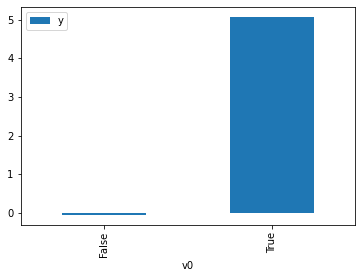

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

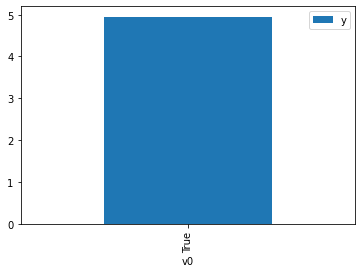

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.151061,False,-0.249701,0.274942,3.637125
1,0.583909,False,-1.142979,0.384252,2.602456
2,-0.837617,False,-0.595851,0.685043,1.459763
3,-0.391391,False,-0.339645,0.595104,1.680378
4,0.211298,False,1.012890,0.463998,2.155183
...,...,...,...,...,...
995,-0.396743,False,-0.211002,0.596237,1.677187
996,-0.937260,False,-1.334596,0.703614,1.421235
997,-0.149952,False,-1.184247,0.543153,1.841103
998,0.090830,False,-0.137512,0.490390,2.039195


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.274685,True,4.242270,0.549818,1.818785
1,-0.458963,True,6.288738,0.390679,2.559645
2,-0.698588,True,4.364895,0.341879,2.925009
3,1.365951,True,5.050833,0.761048,1.313977
4,-1.363955,True,4.802980,0.224549,4.453363
...,...,...,...,...,...
995,-0.888151,True,4.647860,0.305460,3.273751
996,0.743729,True,6.299105,0.648377,1.542312
997,0.264437,True,5.184571,0.547589,1.826188
998,1.627863,True,4.160355,0.800350,1.249453


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.930
Model:                            OLS   Adj. R-squared (uncentered):              0.930
Method:                 Least Squares   F-statistic:                              6621.
Date:                Wed, 03 Aug 2022   Prob (F-statistic):                        0.00
Time:                        08:59:37   Log-Likelihood:                         -1407.2
No. Observations:                1000   AIC:                                      2818.
Df Residuals:                     998   BIC:                                      2828.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4559      0.032     14.205      0.000       0.393       0.519
x2             5.0221      0.046    108.255      0.000       4.931       5.113
==============================================================================
Omnibus:                        0.865   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.649   Jarque-Bera (JB):                0.748
Skew:                           0.055   Prob(JB):                        0.688
Kurtosis:                       3.076   Cond. No.                         1.54
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""